Your model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

In this chapter we’ll use the California Housing Prices dataset from the StatLib repos‐
itory2 (see Figure 2-1). This dataset is based on data from the 1990 California census.
It is not exactly recent (a nice house in the Bay Area was still affordable at the time),
but it has many qualities for learning, so we will pretend it is recent data. For teaching
purposes I’ve added a categorical attribute and removed a few features.

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import re

import pandas as pd
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

### Descriptive Statics

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

In [7]:
housing.corr(method='pearson').sort_values(by='median_income',ascending=False)

longitude  latitude  ...  median_income  median_house_value
median_income       -0.015176 -0.079809  ...       1.000000            0.688075
median_house_value  -0.045967 -0.144160  ...       0.688075            1.000000
total_rooms          0.044568 -0.036100  ...       0.198050            0.134153
households           0.055310 -0.071035  ...       0.013033            0.065843
population           0.099773 -0.108785  ...       0.004834           -0.024650
total_bedrooms       0.069608 -0.066983  ...      -0.007723            0.049686
longitude            1.000000 -0.924664  ...      -0.015176           -0.045967
latitude            -0.924664  1.000000  ...      -0.079809           -0.144160
housing_median_age  -0.108197  0.011173  ...      -0.119034            0.105623

[9 rows x 9 columns]

### Data visualization

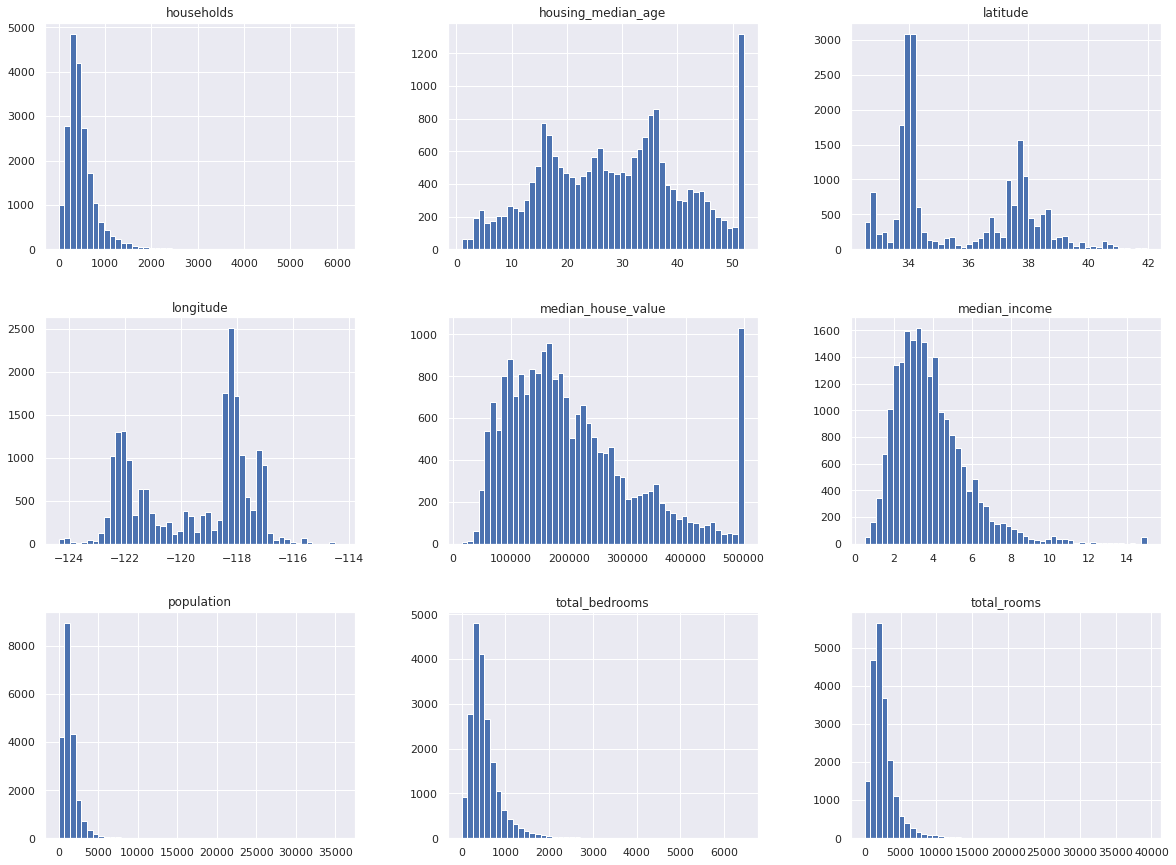

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

1. First, the median income attribute does not look like it is expressed in US dollars
(USD). After checking with the team that collected the data, you are told that the
data has been scaled and capped at 15 (actually, 15.0001) for higher median
incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers
represent roughly tens of thousands of dollars (e.g., 3 actually means about
$30,000). Working with preprocessed attributes is common in Machine Learning,

2. The housing median age and the median house value were also capped. The lat‐
ter may be a serious problem since it is your target attribute (your labels). Your
Machine Learning algorithms may learn that prices never go beyond that limit.
You need to check with your client team (the team that will use your system’s out‐
put) to see if this is a problem or not. If they tell you that they need precise pre‐
dictions even beyond $500,000, then you have two options:

a. Collect proper labels for the districts whose labels were capped.

b. Remove those districts from the training set (and also from the test set, since
your system should not be evaluated poorly if it predicts values beyond
$500,000).

3. These attributes have very different scales. We will discuss this later in this chap‐
ter, when we explore feature scaling.


4. Finally, many histograms are tail-heavy: they extend much farther to the right of
the median than to the left. This may make it a bit harder for some Machine
Learning algorithms to detect patterns. We will try transforming these attributes
later on to have more bell-shaped distributions.

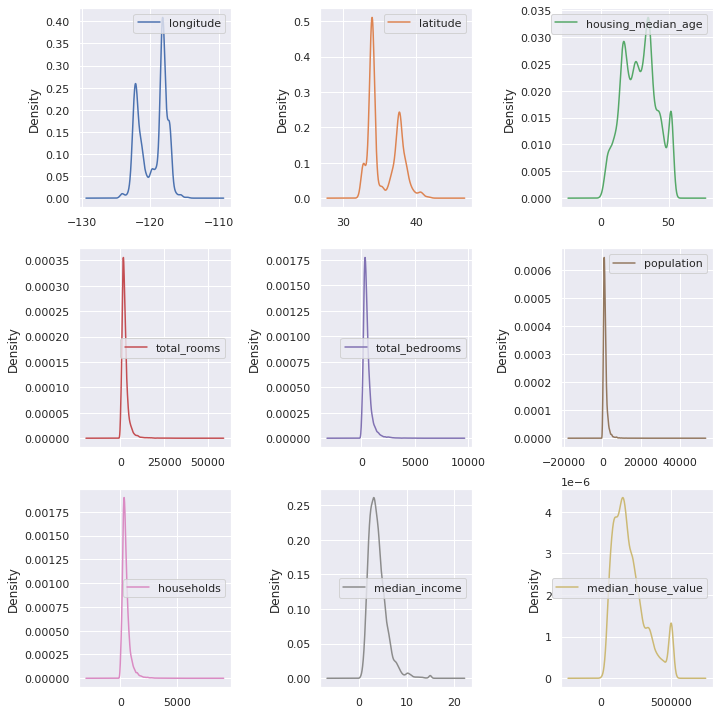

In [9]:
housing.plot(kind='density',subplots=True,layout=(3,3),sharex=False,figsize=(10,10))
plt.tight_layout()

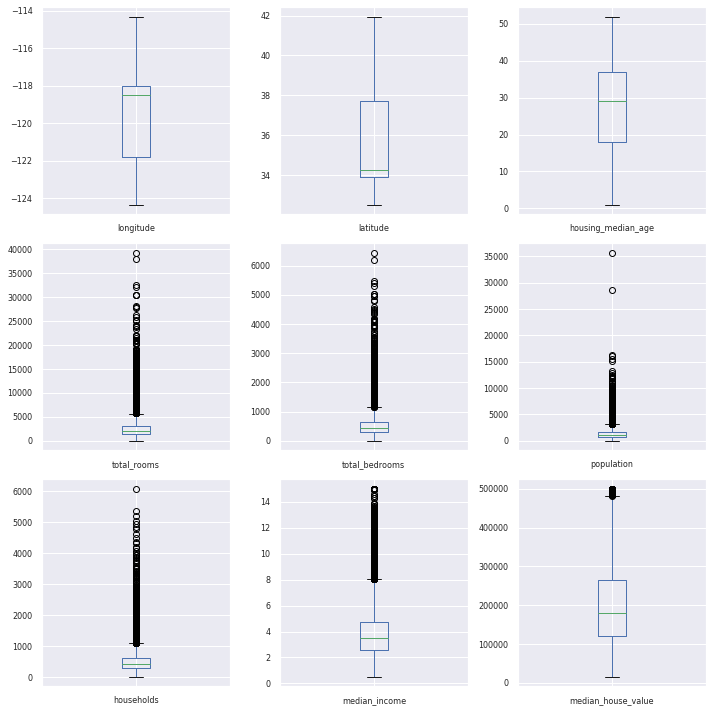

In [10]:
housing.plot(kind='box', subplots=True, layout=(3,3), sharex=False,
fontsize=8,figsize=(10,10))
plt.tight_layout()

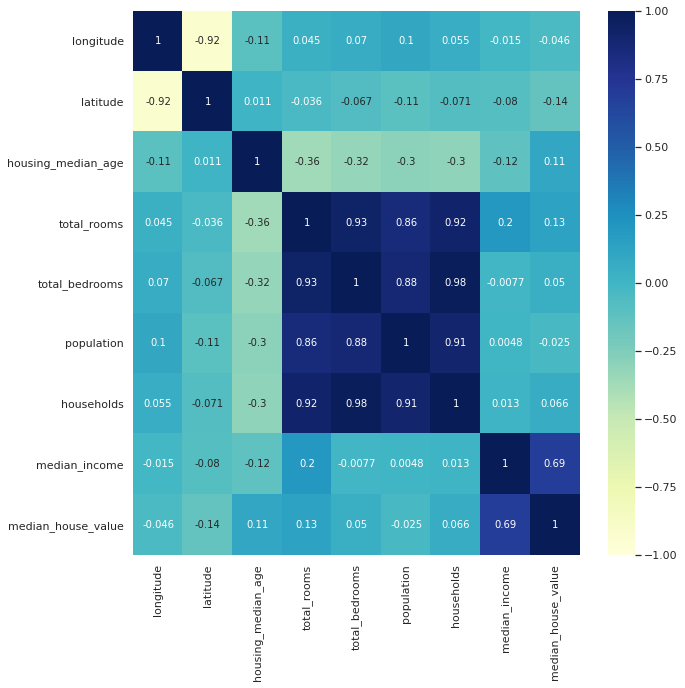

In [11]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(housing.corr(), vmin=-1, vmax=1, annot = True,cmap="YlGnBu",ax=ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3de7f9ca58>,
      dtype=object)

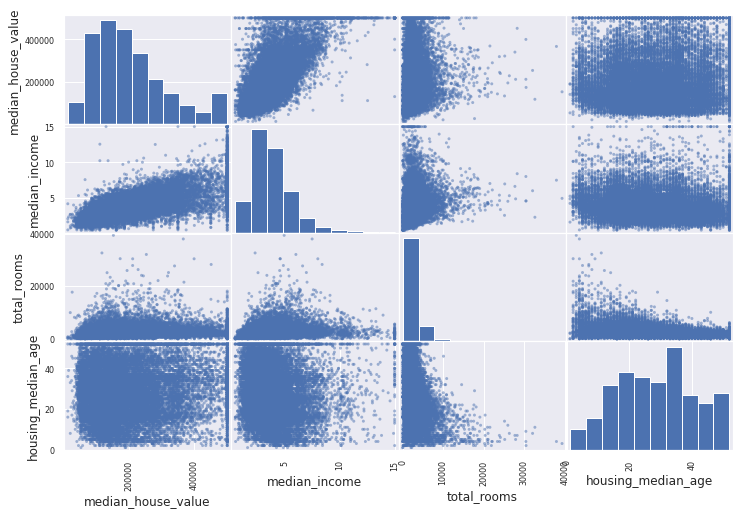

In [12]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0.0, 16.0, 0.0, 550000.0)

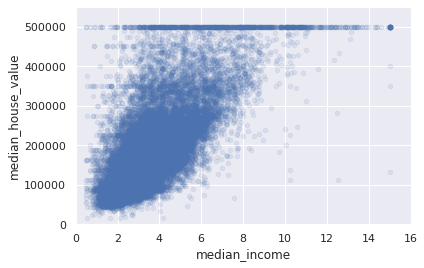

In [13]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

### Discover and Visualize the Data to Gain Insights

In [14]:
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

In [15]:
housing.shape

(20640, 10)

In [0]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [17]:
housing_group=housing.groupby('longitude').mean()
housing_group.reset_index(inplace=True)
housing_group

longitude  latitude  ...  bedrooms_per_room  population_per_household
0      -124.35     40.54  ...           0.164835                  2.985185
1      -124.30     41.82  ...           0.202472                  2.721776
2      -124.27     40.69  ...           0.224777                  2.567742
3      -124.26     40.58  ...           0.177718                  2.457995
4      -124.25     40.28  ...           0.293007                  2.320856
..         ...       ...  ...                ...                       ...
839    -114.56     33.69  ...           0.241667                  2.846154
840    -114.55     32.80  ...           0.319066                  2.353618
841    -114.49     33.97  ...           0.226059                  1.844444
842    -114.47     34.40  ...           0.248497                  2.438445
843    -114.31     34.19  ...           0.228617                  2.150424

[844 rows x 12 columns]

In [18]:
housing_group.describe()

longitude    latitude  ...  bedrooms_per_room  population_per_household
count  844.000000  844.000000  ...         844.000000                844.000000
mean  -119.698389   36.239968  ...           0.208968                  3.117135
std      2.537171    2.400856  ...           0.026936                  3.422225
min   -124.350000   32.700000  ...           0.141661                  1.633094
25%   -121.822500   33.960358  ...           0.192596                  2.622198
50%   -119.715000   36.208545  ...           0.204099                  2.846341
75%   -117.607500   38.242672  ...           0.219888                  3.117249
max   -114.310000   41.880000  ...           0.390517                 77.787133

[8 rows x 12 columns]

In [19]:
housing_group.describe()

longitude    latitude  ...  bedrooms_per_room  population_per_household
count  844.000000  844.000000  ...         844.000000                844.000000
mean  -119.698389   36.239968  ...           0.208968                  3.117135
std      2.537171    2.400856  ...           0.026936                  3.422225
min   -124.350000   32.700000  ...           0.141661                  1.633094
25%   -121.822500   33.960358  ...           0.192596                  2.622198
50%   -119.715000   36.208545  ...           0.204099                  2.846341
75%   -117.607500   38.242672  ...           0.219888                  3.117249
max   -114.310000   41.880000  ...           0.390517                 77.787133

[8 rows x 12 columns]

In [20]:
import folium

import branca
import branca.colormap as cm

x_start = (housing_group['latitude'].max() + housing_group['latitude'].min()) / 2
y_start = (housing_group['longitude'].max() + housing_group['longitude'].min()) / 2
start_coord = (x_start, y_start)

vmin=housing_group['median_house_value'].min()
vmax=housing_group['median_house_value'].max()
#colormap = cm.LinearColormap(colors=['red','lightblue'],vmin=housing_group['median_house_value'].min(),vmax=housing_group['median_house_value'].max())
colormap=cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=vmin, vmax=vmax)

map = folium.Map(location=start_coord, zoom_start=5)

for lat, lon, house_value, room,population in zip(housing_group['latitude'], housing_group['longitude'], 
                                       housing_group['median_house_value'],housing_group['rooms_per_household'],
                                       housing_group['population']):
  folium.CircleMarker(
        [lat, lon],
        radius=population*0.005,
                        popup = (
                                '<strong>House_value: </strong>: ' + str(house_value) + '<br>'
                                '<strong>Room: </strong>: ' + str(room) + '<br>'
                                '<strong>Population: </strong>: ' + str(population) + '<br>'),
        fill=colormap(house_value),
        color=colormap(house_value),
        fill_opacity=0.7
    ).add_to(map)
map.add_child(colormap)
map.save('map.html')
map

In [30]:
housing.head()

longitude  latitude  ...  bedrooms_per_room  population_per_household
0    -122.23     37.88  ...           0.146591                  2.555556
1    -122.22     37.86  ...           0.155797                  2.109842
2    -122.24     37.85  ...           0.129516                  2.802260
3    -122.25     37.85  ...           0.184458                  2.547945
4    -122.25     37.85  ...           0.172096                  2.181467

[5 rows x 13 columns]

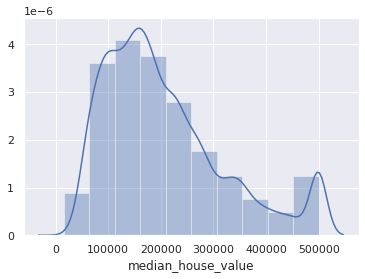

In [35]:
sns.distplot(housing['median_house_value'],bins=10)

ADD more feature

In [0]:
a=housing['median_house_value']
housing.loc[(a<=100000) , 'house_value_cat'] = 'Low' 
housing.loc[((a>100000 ) & (a <=200000)) , 'house_value_cat'] = 'Medium'  
housing.loc[((a>200000 ) & (a <=300000)) , 'house_value_cat'] = 'High'    
housing.loc[(a>300000 ) , 'house_value_cat'] = 'Very_high' 

In [0]:
a=housing['median_house_value']
housing.loc[(a<=100000) , 'house_value_cat'] = 0
housing.loc[((a>100000 ) & (a <=200000)) , 'house_value_cat'] = 1
housing.loc[((a>200000 ) & (a <=300000)) , 'house_value_cat'] = 2    
housing.loc[(a>300000 ) , 'house_value_cat'] = 3

In [71]:
housing['house_value_cat'].value_counts()

Medium       8273
High         4873
Very_high    3836
Low          3658
Name: house_value_cat, dtype: int64

In [73]:
housing.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
house_value_cat              object
dtype: object

In [95]:
#For example iloc columns
X=housing.iloc[:,2:5]
X.head()

housing_median_age  total_rooms  total_bedrooms
0                41.0        880.0           129.0
1                21.0       7099.0          1106.0
2                52.0       1467.0           190.0
3                52.0       1274.0           235.0
4                52.0       1627.0           280.0

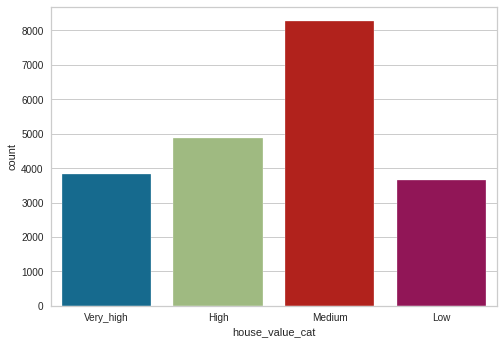

In [96]:
#f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot('house_value_cat',data=housing)
#ax.set_title('Iris Species Count')
plt.show()

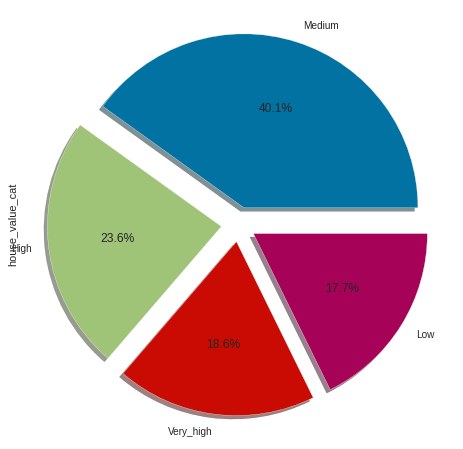

In [98]:
housing['house_value_cat'].value_counts().plot.pie(explode=[0.1,0.1,0.1,0.1],
                                        autopct='%1.1f%%',shadow=True,figsize=(10,8))

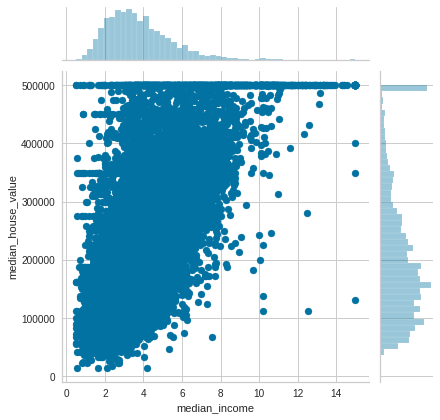

In [103]:
fig=sns.jointplot(x='median_income',y='median_house_value',data=housing)

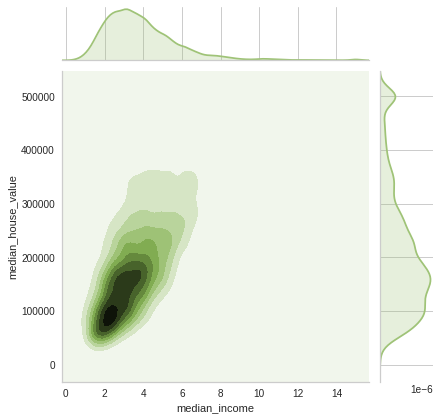

In [104]:
fig=sns.jointplot(x='median_income',y='median_house_value',data=housing,kind='kde',
                  color='g')

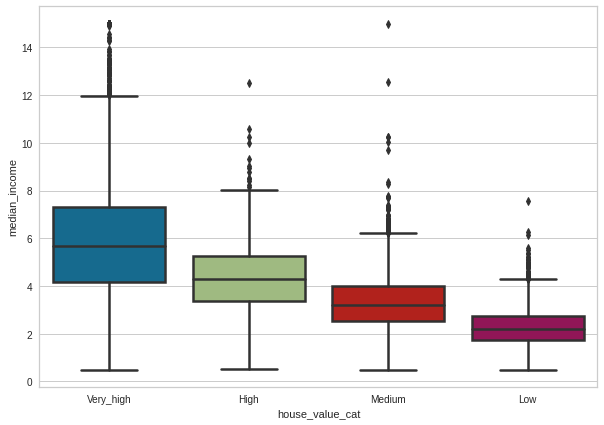

In [105]:
fig=plt.gcf()
fig.set_size_inches(10,7)
fig=sns.boxplot(x='house_value_cat',y='median_income',data=housing,
                #order=['Iris-virginica','Iris-versicolor','Iris-setosa'],
                linewidth=2.5,orient='v',dodge=False)

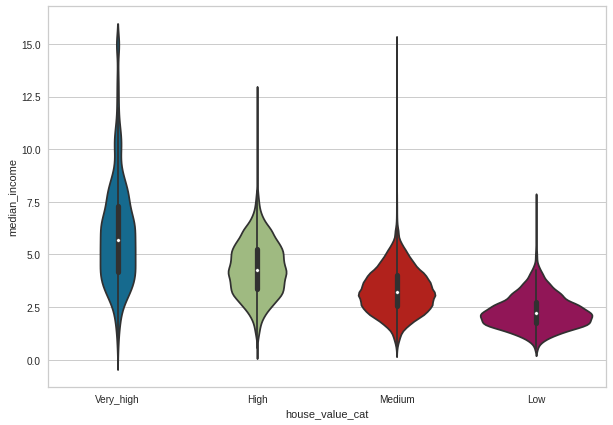

In [107]:
fig=plt.gcf()
fig.set_size_inches(10,7)
fig=sns.violinplot(x='house_value_cat',y='median_income',data=housing)

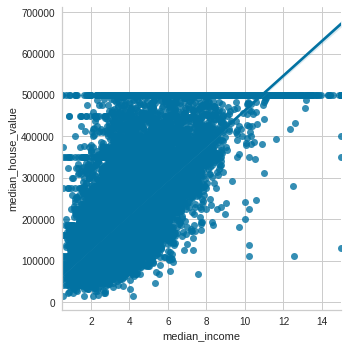

In [108]:
fig=sns.lmplot(x="median_income", y="median_house_value",data=housing)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


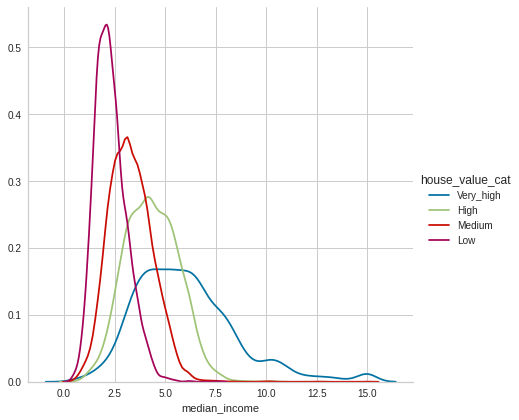

In [109]:
sns.FacetGrid(housing, hue="house_value_cat", size=6) \
   .map(sns.kdeplot, "median_income") \
   .add_legend()
plt.ioff() 

20. Parallel coordinate plot: This type of visualisation is used for plotting multivariate, numerical data. Parallel Coordinates Plots are ideal for comparing many variables together and seeing the relationships between them. For example, if you had to compare an array of products with the same attributes (comparing computer or cars specs across different models).

In [116]:
import plotly.express as px
fig = px.parallel_coordinates(housing, color="house_value_cat",
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             #color_continuous_midpoint=2
                              )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

24.Residual Plot : The most useful way to plot the residuals, though, is with your predicted values on the x-axis, and your residuals on the y-axis. The distance from the line at 0 is how bad the prediction was for that value.

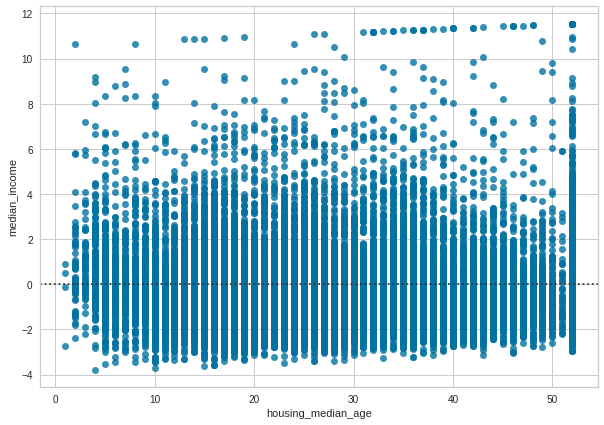

In [122]:
fig=plt.gcf()
fig.set_size_inches(10,7)
fig=sns.residplot('housing_median_age', 'median_income',data=housing,lowess=False)

25.Venn Diagram : A Venn diagram (also called primary diagram, set diagram or logic diagram) is a diagram that shows all possible logical relations between a finite collection of different sets. Each set is represented by a circle. The circle size represents the importance of the group. The groups are usually overlapping: the size of the overlap represents the intersection between both groups.

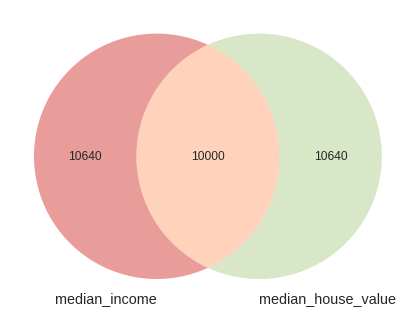

In [128]:
# venn2
from matplotlib_venn import venn2

# First way to call the 2 group Venn diagram
venn2(subsets = (len(housing['median_income'])-10000, len(housing['median_house_value'])-10000, 10000), 
      set_labels = ('median_income', 'median_house_value'))
plt.show()

In [137]:
import plotly.express as px
df = px.data.wind()
fig = px.line_polar(housing, r="median_house_value", theta="ocean_proximity", color="house_value_cat", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
#r : do lon tren tung category
#theta: category tren radar chart
#color: mau sac
fig.show()

In [147]:
trace = go.Scatter3d(
    x = housing['median_house_value'],
    y = housing['median_income'],
    z = housing['population'],
    name = 'Marvel',
    mode = 'markers',
    marker = dict(
         size = 10,
         color = housing['house_value_cat']
    )
)

df = [trace]

layout = go.Layout(
    title = 'Cholestrol vs Heart Rate vs Age',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'median_house_value'),
            yaxis = dict(title  = 'median_income'),
            zaxis = dict(title  = 'population')
        )
    
)
fig = go.Figure(data = df, layout=layout)
fig.show()

<function matplotlib.pyplot.tight_layout>

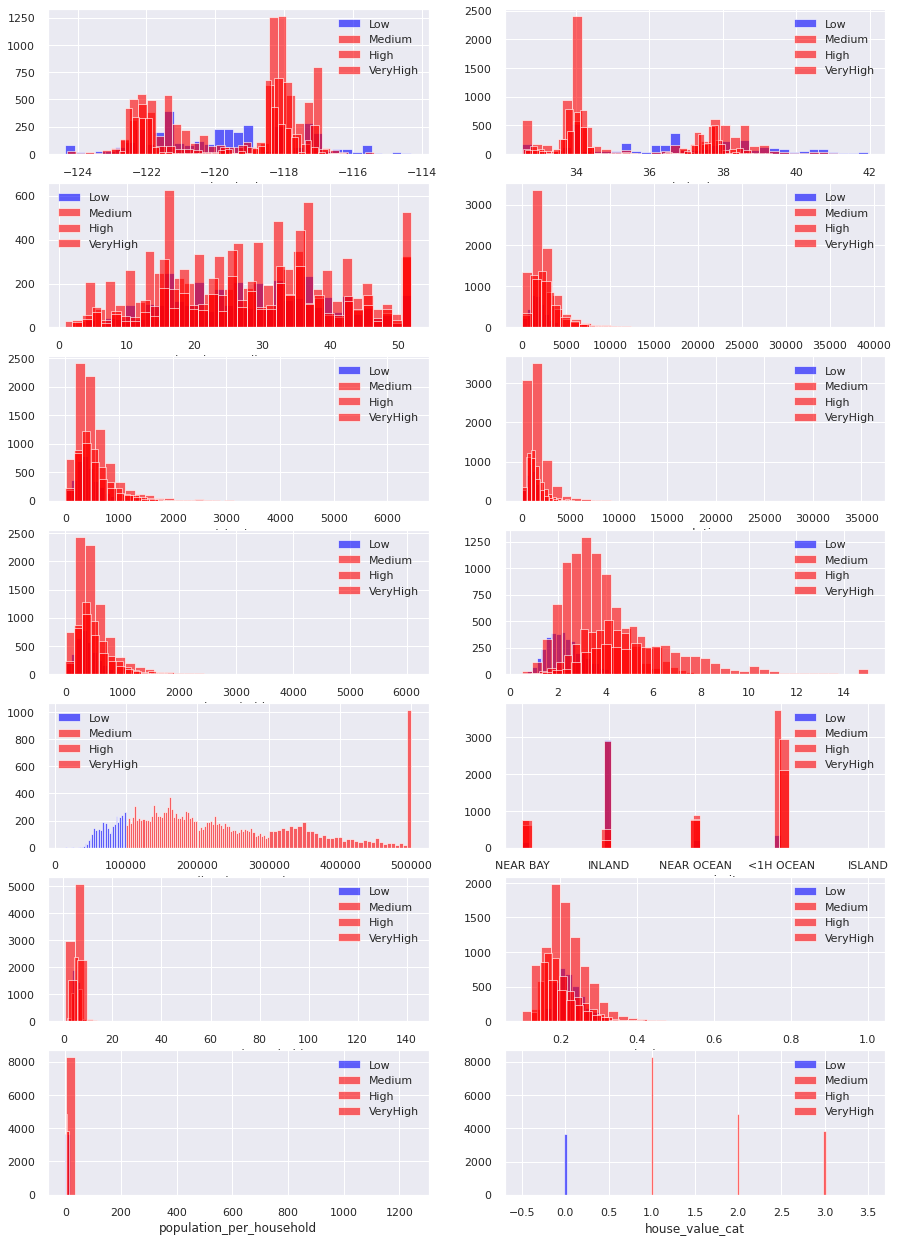

In [149]:
plt.figure(figsize=(15, 25))

for i, column in enumerate(housing.columns, 1):
  plt.subplot(8, 2, i)
  housing[housing["house_value_cat"] == 0][column].hist(bins=35, color='blue', label='Low', alpha=0.6)
  housing[housing["house_value_cat"] == 1][column].hist(bins=35, color='red', label='Medium', alpha=0.6)
  housing[housing["house_value_cat"] == 2][column].hist(bins=35, color='red', label='High', alpha=0.6)
  housing[housing["house_value_cat"] == 3][column].hist(bins=35, color='red', label='VeryHigh', alpha=0.6)
  plt.legend()
  plt.xlabel(column)
plt.tight_layout

In [150]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_room', 'population_per_household', 'house_value_cat'],
      dtype='object')

In [151]:
px.scatter(housing, x="median_income", y="median_house_value", 
           animation_frame="ocean_proximity",
           #animation_group="age",
           size="rooms_per_household", 
           color="house_value_cat", 
           #hover_name="sex",
           #log_x=True, 
           #size_max=55, range_x=[100,100000], range_y=[25,90]
           )

In [0]:
a=housing.sort_values(by='housing_median_age')

In [156]:
px.scatter(a, x="median_income", y="median_house_value", 
           animation_frame="housing_median_age",
           #animation_group="age",
           size="rooms_per_household", 
           color="house_value_cat", 
           #hover_name="sex",
           #log_x=True, 
           #size_max=55, range_x=[100,100000], range_y=[25,90]
           )